# 1. Introduction

Welcome to this notebook where we will venture into the world of Machine Learning with one of its simplest, yet powerful techniques: Linear Regression. Here, we will predict the median price of homes in various Boston neighborhoods, using the widely-used Boston Housing dataset. This is a regression task, meaning we are trying to predict a continuous value (house prices) rather than a discrete label (e.g., spam or not-spam). Let's dive right in!

# 2. Importing the Necessary Libraries

As a good practice, we always start by importing all the libraries we'll need at the top. This makes it clear what our dependencies are, and ensures we have everything we need before we start coding.

In [112]:
import os 
import pandas as pd
import numpy as np 
import torch
from torchvision.io import read_image
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

# 3. Loading the Dataset

Now, let's load the Boston Housing dataset.

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, data, data_path="../data/", transform=None, label_transform=None):
        self.data_path = os.path.normpath(data_path)
        self.transform = transform
        self.label_transform = label_transform

        data = pd.read_csv(os.path.join(self.data_path, data)).values.tolist()

        label, image = [], [] 

        for row in data:
            label.append(row[0])
            image.append(row[1:])
        
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype("float32")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)
        
        if self.label_transform:
            label = self.label_transform(label)

        return image, label

In [37]:
def map_output_to_label(output):
    label_mapping = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
    output_ = (output.item() if type(output) == torch.Tensor else output)
    return label_mapping[output_]

In [26]:
train_data = CustomImageDataset(data="fashion-mnist_train.csv", transform=transforms.Compose([transforms.ToTensor()]))
test_data = CustomImageDataset(data="fashion-mnist_test.csv", transform=transforms.Compose([transforms.ToTensor()]))

In [27]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [85]:
num_labels = len(np.unique(train_data.labels))

# 4. Preprocessing for EDA ( if necessary )

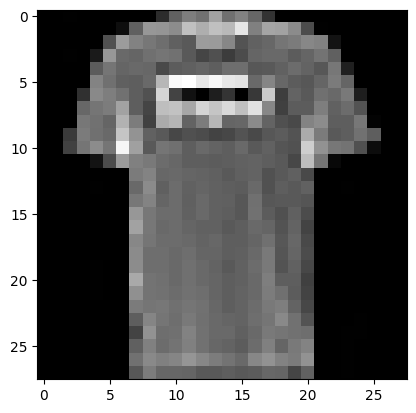

In [79]:
image, label = next(iter(train_dataloader))
plt.imshow(image.squeeze()[0], cmap="gray")

# 5. Exploratory Data Analysis ( EDA )

Before we dive into modeling, it's a good idea to explore our dataset. This can include looking at the raw data, checking for missing values, visualizing the distributions of variables, and understanding the relationships between different variables. See at `cheatsheets/...` for a Cheat Sheet on all the basic things to look for.

In [74]:
# No need here

# 6. Data Preprocessing

Before we dive into modeling, it's a good idea to explore our dataset. This can include looking at the raw data, checking for missing values, visualizing the distributions of variables, and understanding the relationships between different variables. See at `cheatsheets/Preprocessing.md` for a Cheat Sheet on all the basic things to look for.

In [75]:
# Done inside of the CustomImageDataset class

# 7. Model Implementation

Finally, we come to the heart of our notebook: implementing the Linear Regression model! We'll fit the model to our training data and make predictions on our testing data.

In [100]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels),
        )

    def forward(self, x):
        return self.layers(x)

In [101]:
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


tensor([6], device='mps:0') Shirt


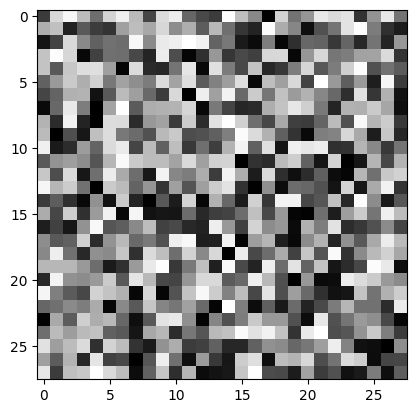

In [119]:
X = torch.rand(1, 28, 28, 1).to(device)
logits = model(X)
m = nn.Softmax(dim=1)
sol_tensor = m(logits).argmax(dim=1)
print(sol_tensor, map_output_to_label(sol_tensor))
# Clearly not trained yet
plt.imshow(X.squeeze().cpu(), cmap="gray")

In [106]:
num_epochs = 10
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if i % 1000:
            losses.append((i,loss.item())) 

<Axes: >

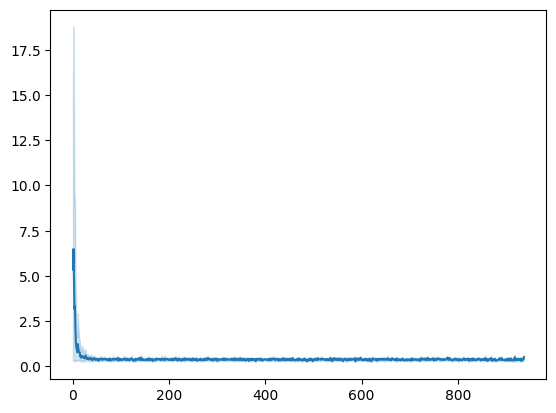

In [113]:
sns.lineplot(x=[i[0] for i in losses], y=[i[1] for i in losses])

In [114]:
losses[-1]

(937, 0.5271424651145935)

# 8. Model Evaluation

After we've made our predictions, we need to evaluate how well our model did. This will usually involve some sort of error metric, like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).

In [110]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

Accuracy of the network on the 10000 test images: 87.3%


# 9. Conclusion

In this final section, we'll recap what we've done and learned in this notebook. We might also discuss what we could do in future projects or how we could improve our current model.

Remember, these are just guidelines. Your notebook should reflect your own style and approach to data science. The most important thing is that your notebook is clear, logical, and informative. Happy coding!

Note: You can insert these section headings into your Jupyter notebook by changing a cell's type to "Markdown" and typing in the text. You can run a markdown cell in the same way you'd run a code cell (Shift+Enter).

--- Conclusion ---